## Model Part 3
* SVN using radial kernel, as data is overlapping in EDA pairplots and not visible linear separation
* rbf kernel implicitly transforms input features into a higher dimensional space, and try find the hyperplane that separate them. Transformation is implicit, hence will not be able to map back to the original features..

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC

sns.set_style('whitegrid') # set style for visualization
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/features_engineered.csv', encoding='utf-8')
df

,SUBJECT_ID,SESSION_ID,TRIAL_ID,c_ml_min_r,c_ml_max_r,c_ml_min_l,c_ml_max_l,c_ap_slope_r,c_ap_slope_l,g_ml_max1_r,...,g_v_max1_r,g_v_min_r,g_v_max2_r,g_v_max1_l,g_v_min_l,g_v_max2_l,AGE,BMI,CLASS_LABEL,SPEED
0,510,413,1,0.087271,0.118247,0.087814,0.128115,0.001718,0.002493,0.072643,...,1.035925,0.818121,0.987930,1.083287,0.796622,1.003385,47,35.538442,C,2
1,510,413,2,0.085806,0.128396,0.040212,0.083074,0.001589,0.001834,0.072360,...,1.009803,0.819649,0.991990,1.018526,0.837006,0.999401,47,35.538442,C,2
2,510,413,3,0.073788,0.112735,0.049990,0.099952,0.001740,0.001734,0.059417,...,1.010970,0.823223,0.989883,1.049092,0.815221,1.003578,47,35.538442,C,2
3,510,413,4,0.056216,0.102832,0.086729,0.127982,0.001919,0.001361,0.079792,...,1.047625,0.797822,1.005463,1.118118,0.773203,1.021851,47,35.538442,C,2
4,510,413,6,0.064922,0.102404,0.000573,0.052266,0.001837,0.002049,0.059537,...,1.044787,0.780821,1.009273,1.084354,0.820851,1.027245,47,35.538442,C,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70611,93,999910373,7,-0.019602,-0.001001,0.103706,0.140610,0.001320,0.001493,0.035459,...,1.094816,0.766321,1.150030,1.028103,0.776455,1.163370,53,21.651307,HC,2
70612,93,999910373,8,0.053761,0.060738,-0.024844,-0.006204,0.001334,0.002134,0.046960,...,1.164835,0.742256,1.134485,1.077298,0.753378,1.144916,53,21.651307,HC,2
70613,93,999910373,9,0.043214,0.068197,0.038681,0.053585,0.001676,0.001885,0.047020,...,1.174641,0.781061,1.103683,1.037734,0.764046,1.153042,53,21.651307,HC,2
70614,93,999910373,10,0.049181,0.060193,-0.036239,-0.007429,0.002073,0.001640,0.026953,...,1.136903,0.753482,1.167718,1.039462,0.779464,1.158905,53,21.651307,HC,2


In [3]:
df.isna().sum().loc[lambda x : x>0].sort_values(ascending=False)

BMI    26992
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df.shape

(43624, 29)

In [6]:
df.columns

Index(['SUBJECT_ID', 'SESSION_ID', 'TRIAL_ID', 'c_ml_min_r', 'c_ml_max_r',
       'c_ml_min_l', 'c_ml_max_l', 'c_ap_slope_r', 'c_ap_slope_l',
       'g_ml_max1_r', 'g_ml_min_r', 'g_ml_max2_r', 'g_ml_max1_l', 'g_ml_min_l',
       'g_ml_max2_l', 'g_ap_min_r', 'g_ap_max_r', 'g_ap_min_l', 'g_ap_max_l',
       'g_v_max1_r', 'g_v_min_r', 'g_v_max2_r', 'g_v_max1_l', 'g_v_min_l',
       'g_v_max2_l', 'AGE', 'BMI', 'CLASS_LABEL', 'SPEED'],
      dtype='object')

### SVN

In [7]:
# https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html
# https://stackoverflow.com/questions/36232334/plotting-3d-decision-boundary-from-linear-svm

In [8]:
#prepare the data
X= df[['c_ml_min_r', 'c_ml_max_r',
       'c_ml_min_l', 'c_ml_max_l', 'c_ap_slope_r', 'c_ap_slope_l',
       'g_ml_max1_r', 'g_ml_min_r', 'g_ml_max2_r', 'g_ml_max1_l', 'g_ml_min_l',
       'g_ml_max2_l', 'g_ap_min_r', 'g_ap_max_r', 'g_ap_min_l', 'g_ap_max_l',
       'g_v_max1_r', 'g_v_min_r', 'g_v_max2_r', 'g_v_max1_l', 'g_v_min_l',
       'g_v_max2_l','AGE','BMI']]
y = df['CLASS_LABEL']
y

0         C
1         C
2         C
3         C
4         C
         ..
70611    HC
70612    HC
70613    HC
70614    HC
70615    HC
Name: CLASS_LABEL, Length: 43624, dtype: object

In [9]:
numeric_features = ['c_ml_min_r', 'c_ml_max_r',
       'c_ml_min_l', 'c_ml_max_l', 'c_ap_slope_r', 'c_ap_slope_l',
       'g_ml_max1_r', 'g_ml_min_r', 'g_ml_max2_r', 'g_ml_max1_l', 'g_ml_min_l',
       'g_ml_max2_l', 'g_ap_min_r', 'g_ap_max_r', 'g_ap_min_l', 'g_ap_max_l',
       'g_v_max1_r', 'g_v_min_r', 'g_v_max2_r', 'g_v_max1_l', 'g_v_min_l',
       'g_v_max2_l','AGE','BMI']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = []
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", SVC(gamma='auto',kernel = "rbf", C=10))]
)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [11]:
X_train.shape

(32718, 24)

In [12]:
%%time
clf.fit(X_train, y_train)

CPU times: total: 2min
Wall time: 2min 21s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['c_ml_min_r', 'c_ml_max_r',
                                                   'c_ml_min_l', 'c_ml_max_l',
                                                   'c_ap_slope_r',
                                                   'c_ap_slope_l',
                                                   'g_ml_max1_r', 'g_ml_min_r',
                                                   'g_ml_max2_r', 'g_ml_max1_l',
                                                   'g_ml_min_l', 'g_ml_max2_l',
                                                   'g_ap_min_r', 'g_ap_max_r',
                                                   'g_ap_min_l', 'g_ap_max_l',
                                                   'g_v_max1_r', 'g_v_min_r',
                                                   'g_v_max2_r', 'g_v_max1_l',
                                                   'g_v_min_l', 'g_v_max2_l',
                                                   'AGE', 'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier', SVC(C=10, gamma='auto'))])

In [13]:
%%time
print(f'Score on training set: {clf.score(X_train, y_train)}')
print(f'Score on testing set: {clf.score(X_test, y_test)}')

Score on training set: 0.9344091937159973
Score on testing set: 0.8299101412066753
CPU times: total: 1min 56s
Wall time: 2min


In [14]:
pred = clf.predict(X_test)
pred

array(['A', 'HC', 'A', ..., 'A', 'K', 'HC'], dtype=object)

In [15]:
#Create confusion matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[3354  134   73   49  253]
 [ 233 1587   20   11   53]
 [ 140   21 1308   35  131]
 [  81    7   33  470   69]
 [ 279   57  128   48 2332]]


In [16]:
clf.classes_

array(['A', 'C', 'H', 'HC', 'K'], dtype=object)

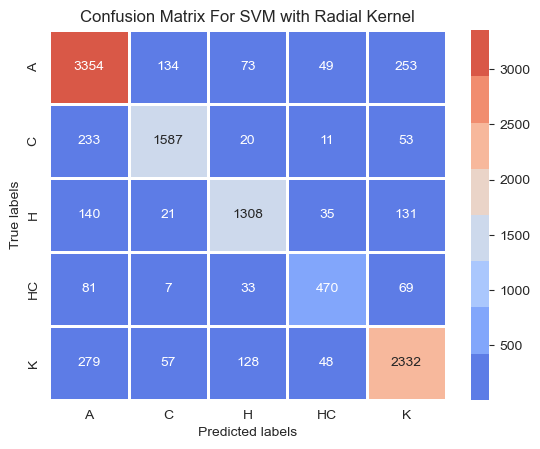

In [17]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("coolwarm", 8), linewidths=1, linecolor='w');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For SVM with Radial Kernel'); 
ax.xaxis.set_ticklabels(clf.classes_); 
ax.yaxis.set_ticklabels(clf.classes_);

In [19]:
accuracy_score(y_test,pred)

0.8299101412066753

In [20]:
def confusion_matrix_metrics(cls, cm):
    TP = cm[cls, cls]
    FN = cm[cls].sum() - TP
    FP = cm[:, cls].sum() - TP
    TN = cm.sum() - TP - FN - FP
    return np.array([[TP, FN], [FP, TN]])

In [23]:
for cls in range(cm.shape[0]):
    print(f'[Class {clf.classes_[cls]} vs others]')
    TP, FN, FP, TN = confusion_matrix_metrics(cls, cm).ravel()
    print(f'TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}')

[Class A vs others]
TP: 3354, FN: 509, FP: 733, TN: 6310
[Class C vs others]
TP: 1587, FN: 317, FP: 219, TN: 8783
[Class H vs others]
TP: 1308, FN: 327, FP: 254, TN: 9017
[Class HC vs others]
TP: 470, FN: 190, FP: 143, TN: 10103
[Class K vs others]
TP: 2332, FN: 512, FP: 506, TN: 7556


In [28]:
print(classification_report(y_test, pred,target_names=clf.classes_))

              precision    recall  f1-score   support

           A       0.82      0.87      0.84      3863
           C       0.88      0.83      0.86      1904
           H       0.84      0.80      0.82      1635
          HC       0.77      0.71      0.74       660
           K       0.82      0.82      0.82      2844

    accuracy                           0.83     10906
   macro avg       0.83      0.81      0.82     10906
weighted avg       0.83      0.83      0.83     10906



## Grid search

In [27]:
dict(classifier__gamma=gamma_range, classifier__C=C_range)

{'classifier__gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
        1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'classifier__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])}

In [ ]:
%%time
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(classifier__gamma=gamma_range, classifier__C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
gs_svc = GridSearchCV(estimator = clf,
                    param_grid = param_grid,
                    cv=cv)
gs_svc.fit(X_train, y_train)

In [ ]:
%%time
print("Best params:")
print(gs_svc.best_params_)
print(f"Training CV score: {gs_svc.best_score_:.3f}")